In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from kneed import KneeLocator
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA
import hdbscan
from sklearn.mixture import GaussianMixture



# Task 1: Basel Climate Dataset

In [94]:
basel_df = pd.read_csv('data/ClimateDataBasel.csv')

In [95]:
# info
basel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temp_min_c     1763 non-null   float64
 1   temp_max_c     1763 non-null   float64
 2   temp_mean_c    1763 non-null   float64
 3   rh_min_pct     1763 non-null   int64  
 4   rh_max_pct     1763 non-null   int64  
 5   rh_mean_pct    1763 non-null   float64
 6   slp_min_hpa    1763 non-null   float64
 7   slp_max_hpa    1763 non-null   float64
 8   slp_mean_hpa   1763 non-null   float64
 9   precip_mm      1763 non-null   float64
 10  snow_cm        1763 non-null   float64
 11  sunshine_min   1763 non-null   float64
 12  gust_min_kmh   1763 non-null   float64
 13  gust_max_kmh   1763 non-null   float64
 14  gust_mean_kmh  1763 non-null   float64
 15  wind_min_kmh   1763 non-null   float64
 16  wind_max_kmh   1763 non-null   float64
 17  wind_mean_kmh  1763 non-null   float64
dtypes: float

In [96]:
# describe
basel_df.describe()

,temp_min_c,temp_max_c,temp_mean_c,rh_min_pct,rh_max_pct,rh_mean_pct,slp_min_hpa,slp_max_hpa,slp_mean_hpa,precip_mm,snow_cm,sunshine_min,gust_min_kmh,gust_max_kmh,gust_mean_kmh,wind_min_kmh,wind_max_kmh,wind_mean_kmh
count,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000,1763.000000
mean,8.738776,16.779298,12.717350,54.092456,87.004538,71.040509,1014.690925,1020.364492,1017.576393,1.502893,0.068015,399.168240,7.235326,30.464208,17.567084,2.932845,14.858762,8.418839
std,7.803700,9.647769,8.788555,12.949827,7.892077,10.012178,8.848251,8.014133,8.282298,3.496710,0.513935,294.660868,8.221851,16.491422,11.504750,3.470768,7.871249,5.205606
min,-12.519471,-4.389471,-7.628222,19.000000,53.000000,38.333332,976.100000,981.400000,978.450000,0.000000,0.000000,0.000000,0.000000,4.320000,2.715000,0.000000,2.881557,1.495064
25%,1.700529,8.200529,4.689279,44.000000,82.000000,63.520834,1010.300000,1015.900000,1013.233400,0.000000,0.000000,123.972160,2.160000,19.080000,9.765000,0.842431,9.304952,4.872080
50%,10.210529,17.400530,14.618446,54.000000,88.000000,72.000000,1014.600000,1019.500000,1016.954040,0.000000,0.000000,387.746280,4.320000,26.280000,14.145000,1.864800,12.988194,6.939507
75%,15.530529,25.190529,20.432404,64.000000,93.000000,78.750000,1019.300000,1024.400000,1021.760405,1.200000,0.000000,619.156720,8.820000,37.440000,21.667500,3.729600,18.398964,10.108294
max,25.820530,36.700527,30.425112,93.000000,100.000000,95.250000,1043.600000,1049.900000,1047.095800,37.399994,13.860001,962.283300,57.960000,133.200000,90.749990,26.673279,59.192370,36.360706


In [97]:
# Handling missing data
columns = basel_df.columns

missing_summary = pd.DataFrame({
    "Missing Values": basel_df.isna().sum(),
    "Percentage": basel_df.isna().mean() * 100
}).sort_values(by="Missing Values")

missing_summary

,Missing Values,Percentage
temp_min_c,0,0.0
wind_min_kmh,0,0.0
gust_mean_kmh,0,0.0
gust_max_kmh,0,0.0
gust_min_kmh,0,0.0
sunshine_min,0,0.0
snow_cm,0,0.0
precip_mm,0,0.0
slp_mean_hpa,0,0.0
slp_max_hpa,0,0.0


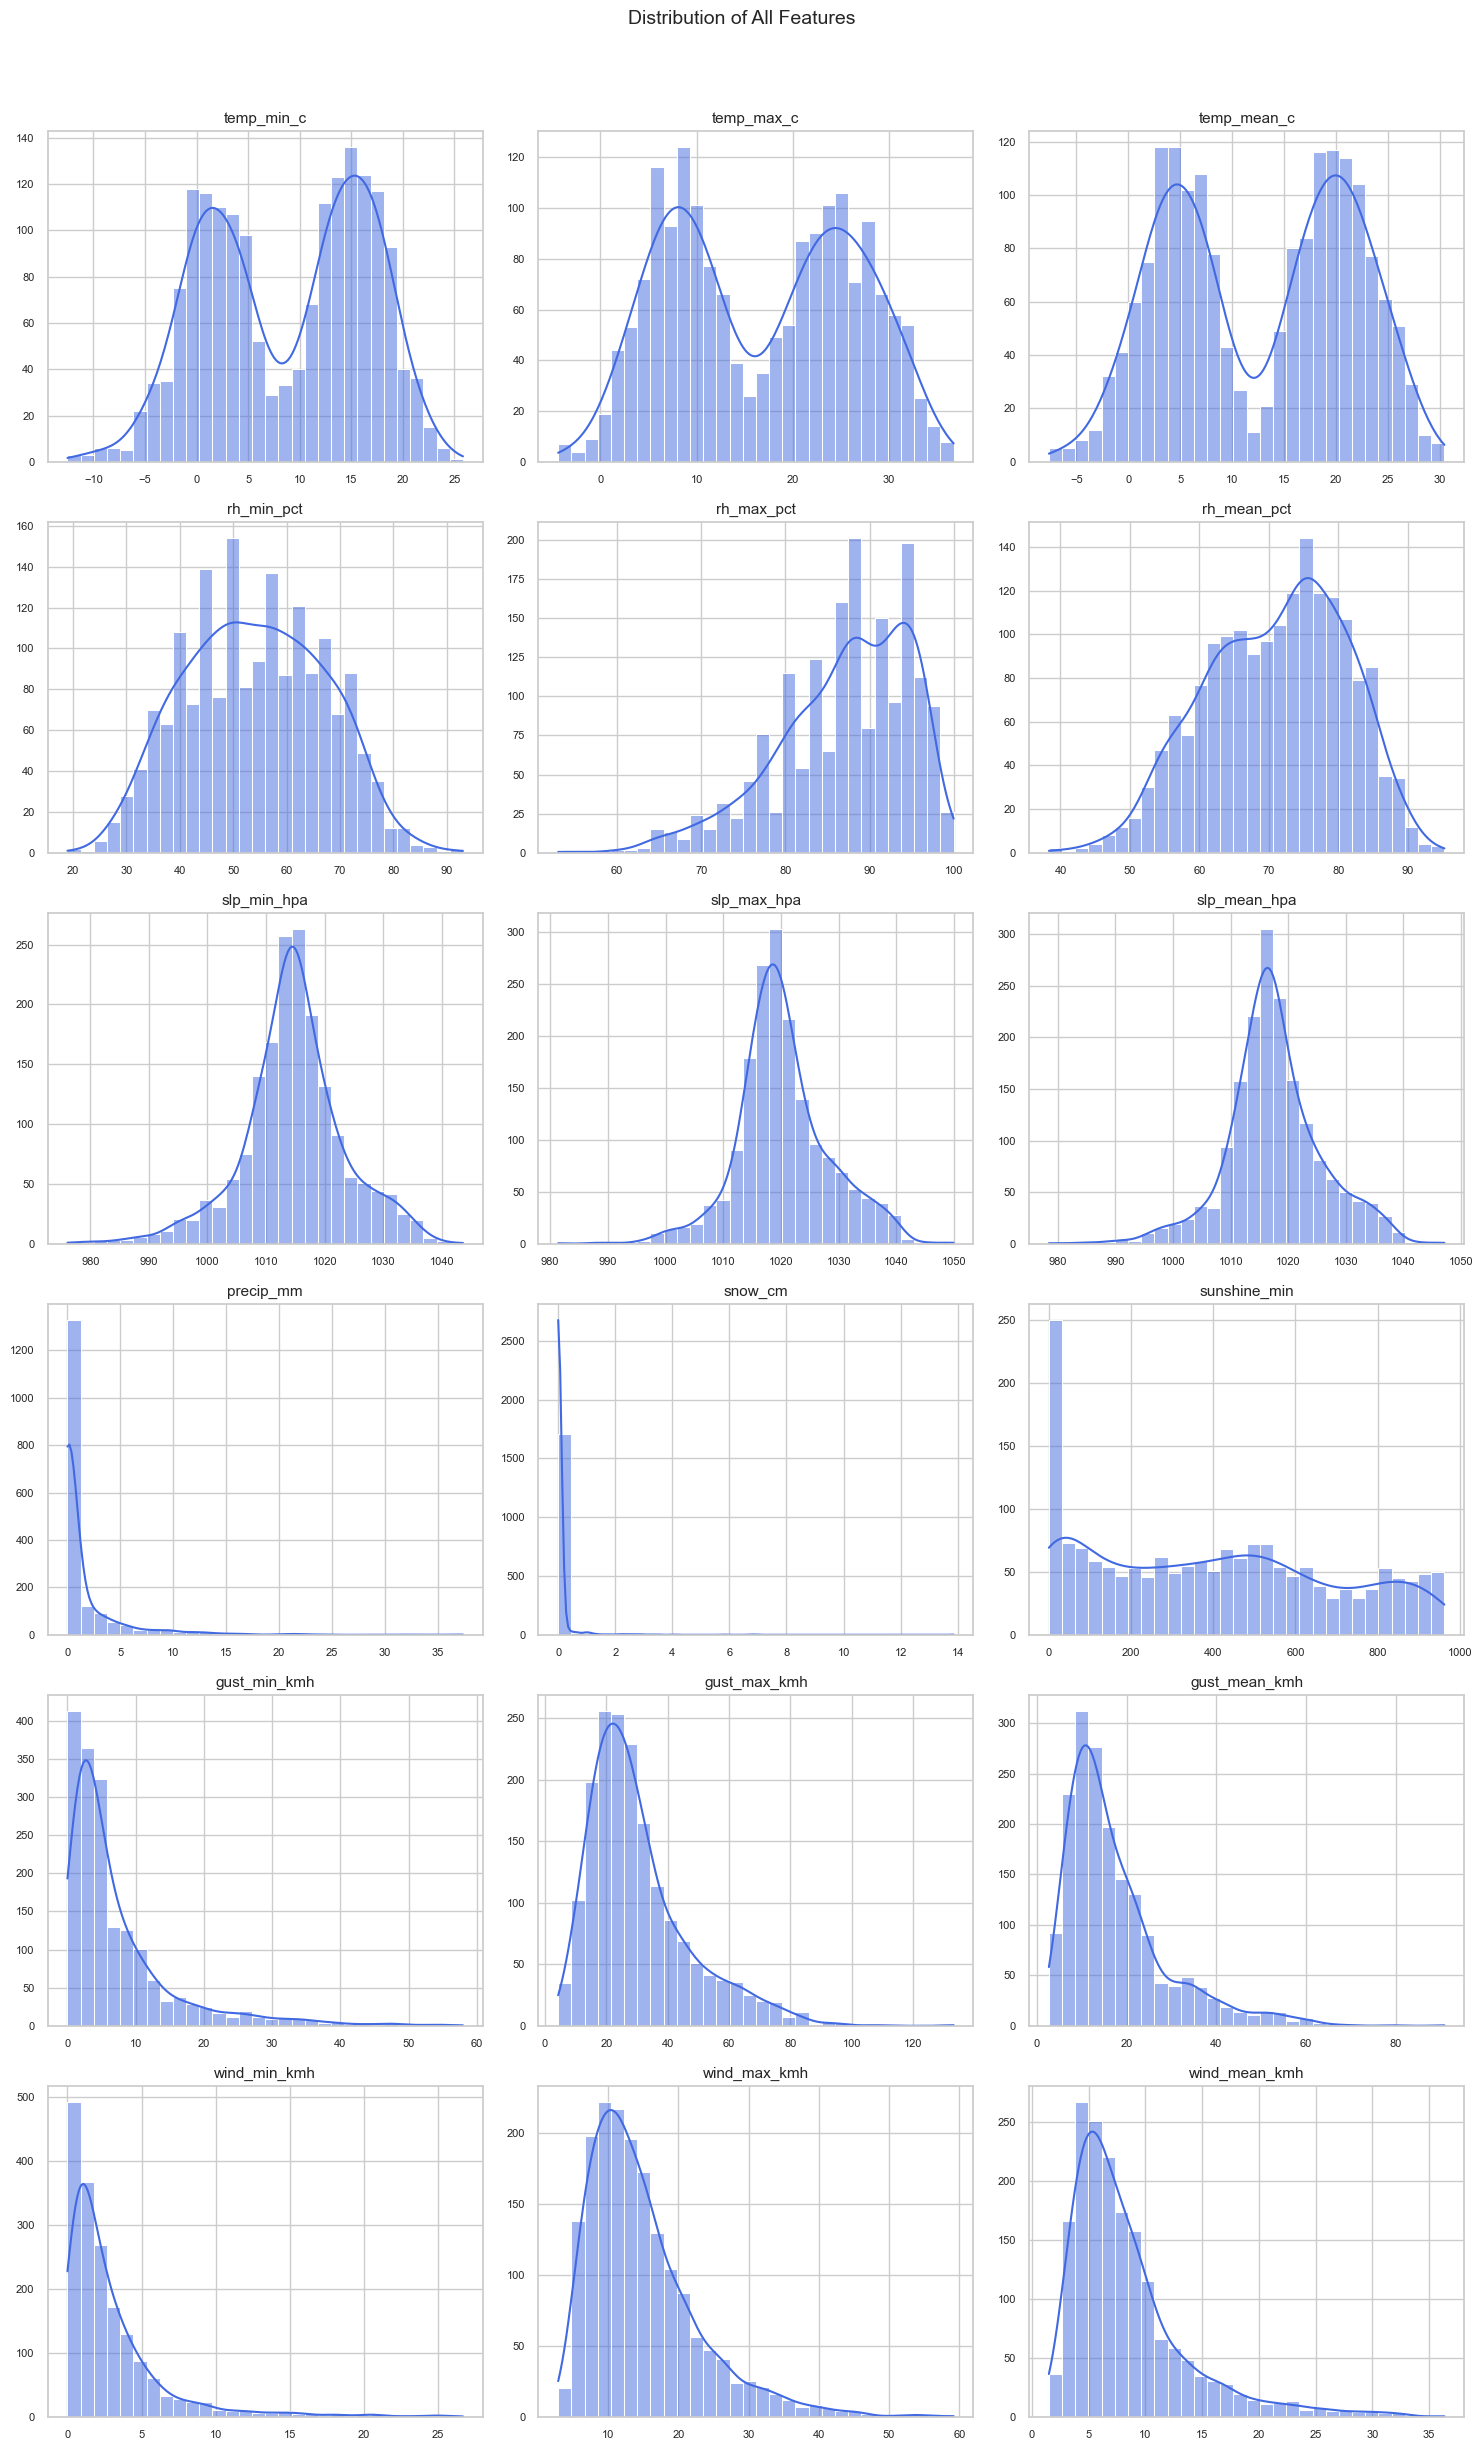

In [98]:
# select only numerical columns
num_cols = basel_df.select_dtypes(include=["number"]).columns

sns.set(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.figsize": (5, 4),
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.histplot(basel_df[col], bins=30, kde=True, ax=axes[i], color="royalblue", edgecolor="white")
  axes[i].set_title(col, fontsize=11)
  axes[i].set_xlabel("")
  axes[i].set_ylabel("")
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.suptitle("Distribution of All Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("images/dist_all_features.png")
plt.show()



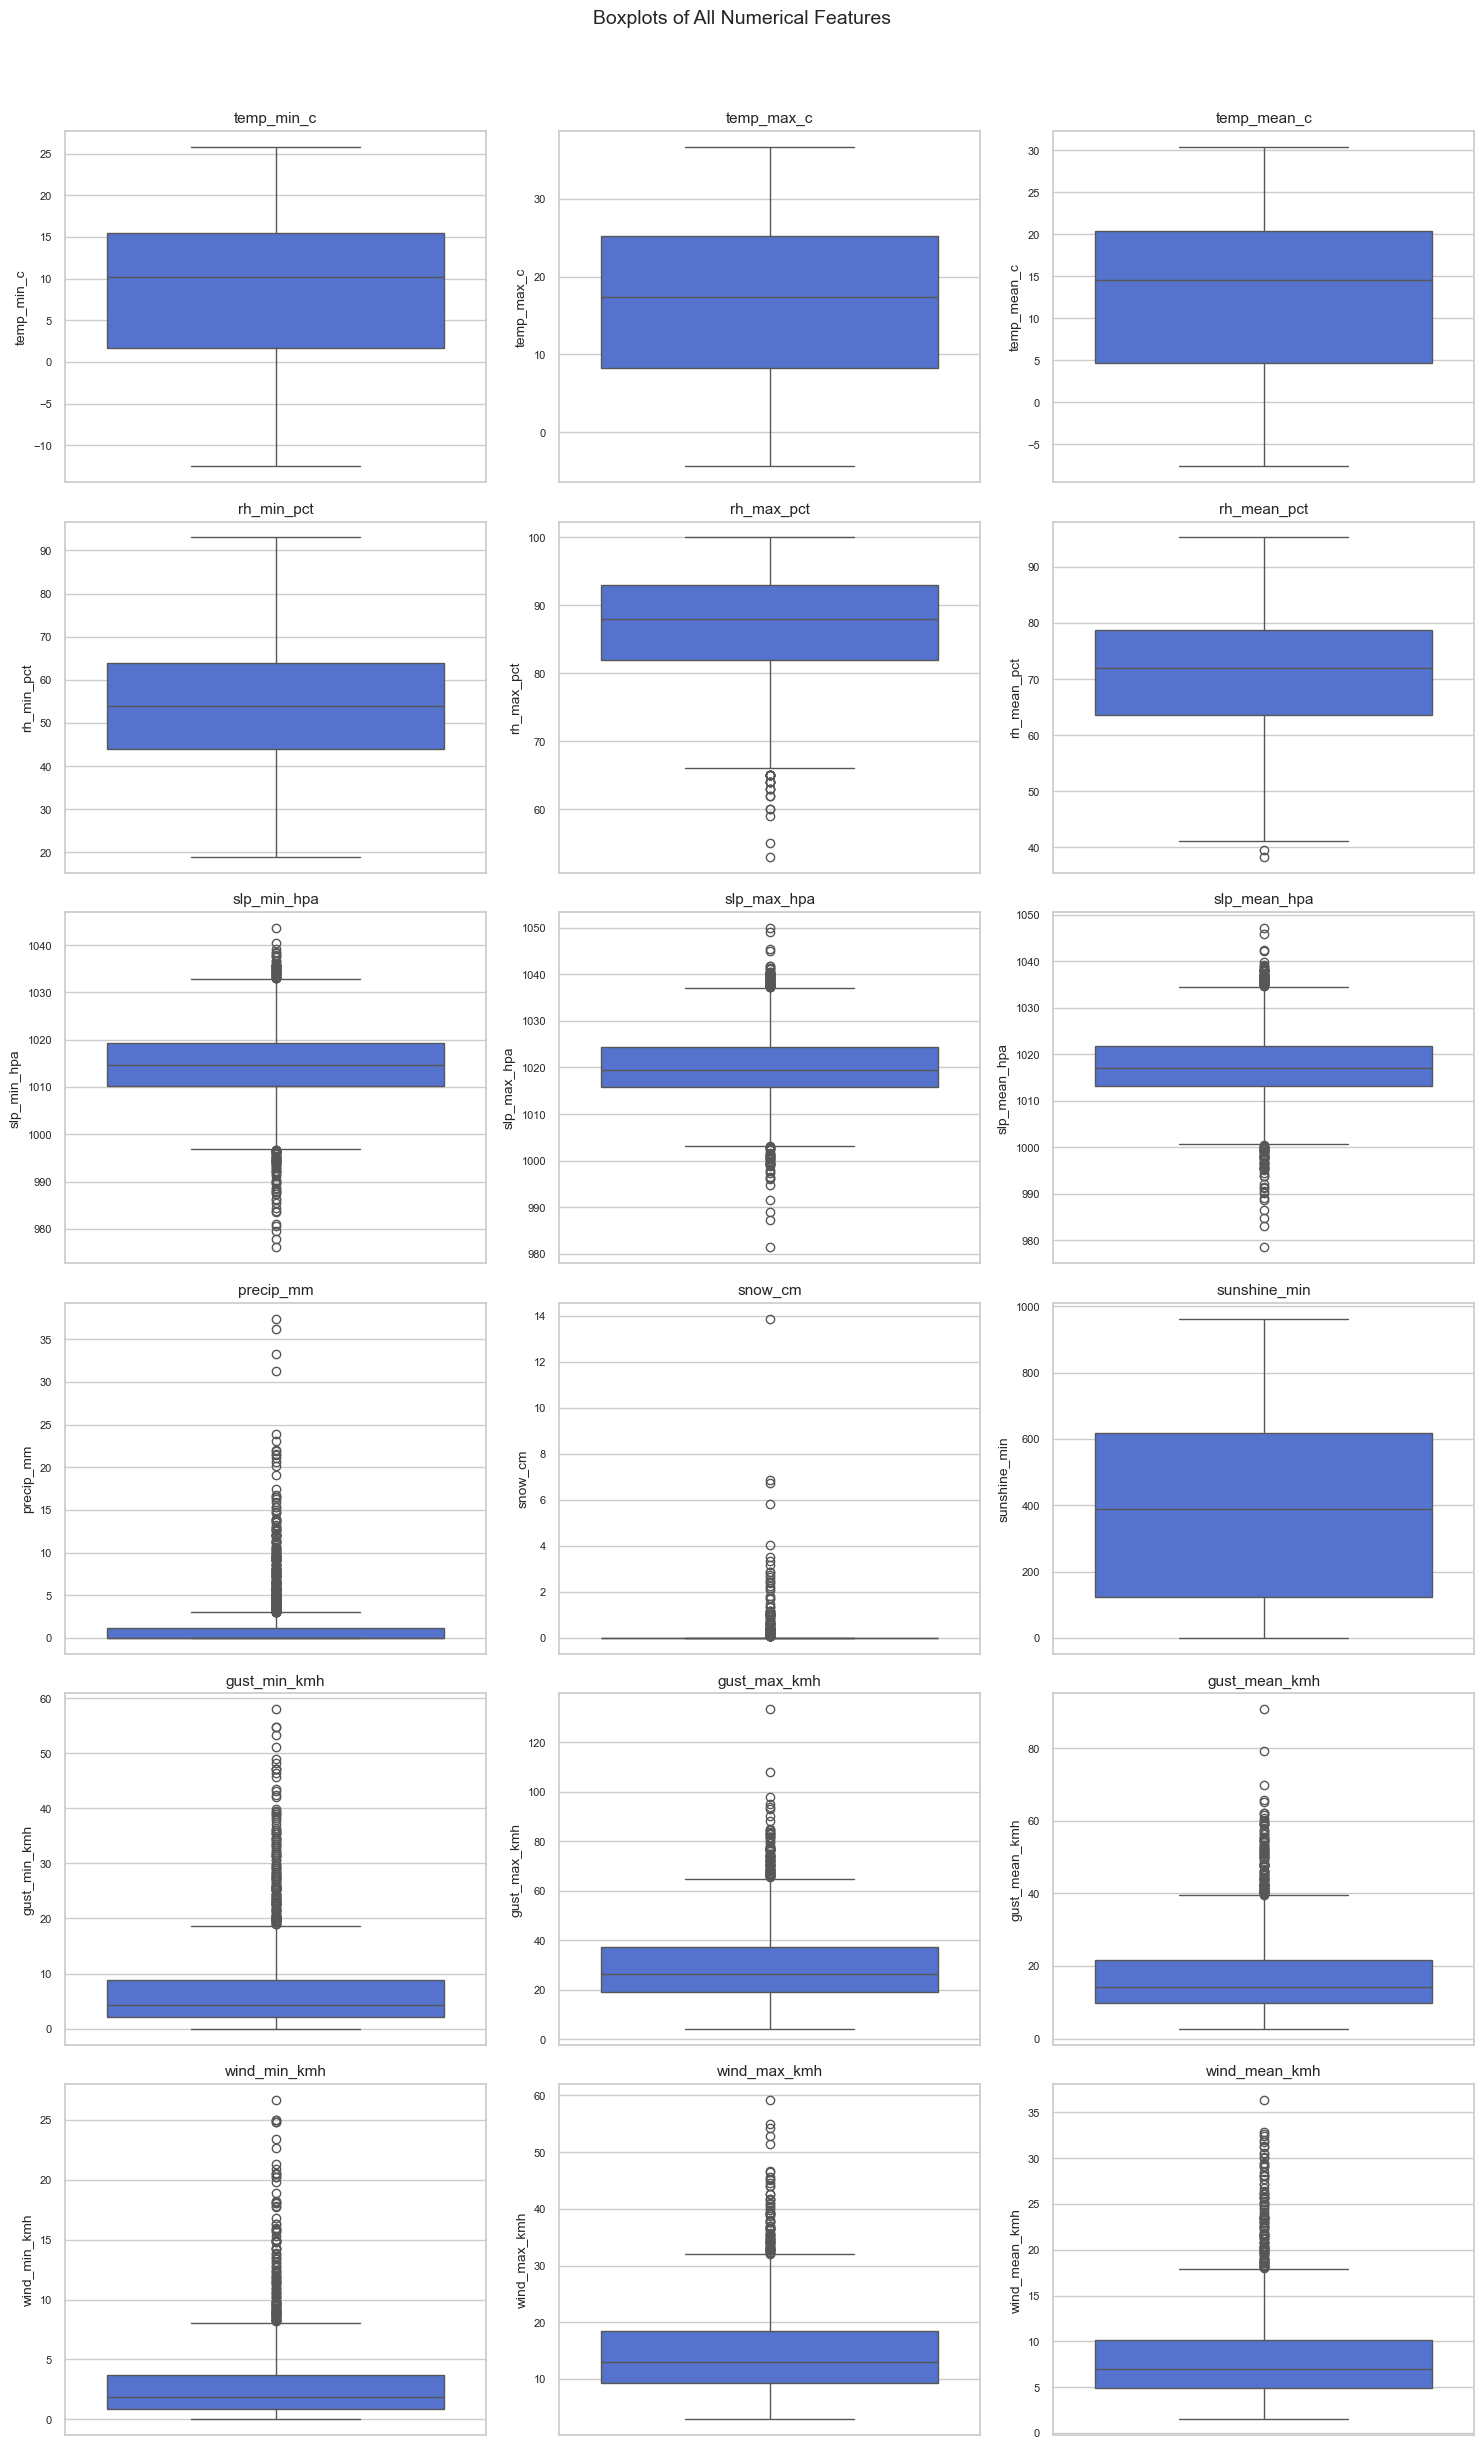

In [99]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
  sns.boxplot(y=basel_df[col], ax=axes[i], color="royalblue")
  axes[i].set_title(col, fontsize=11)
  axes[i].set_xlabel("")

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.suptitle("Boxplots of All Numerical Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("images/boxplot_features.png")
plt.show()

In [100]:
scaler = RobustScaler()
basel_df_scaled = pd.DataFrame(
    scaler.fit_transform(basel_df[num_cols]),
    columns=num_cols,
    index=basel_df.index
)

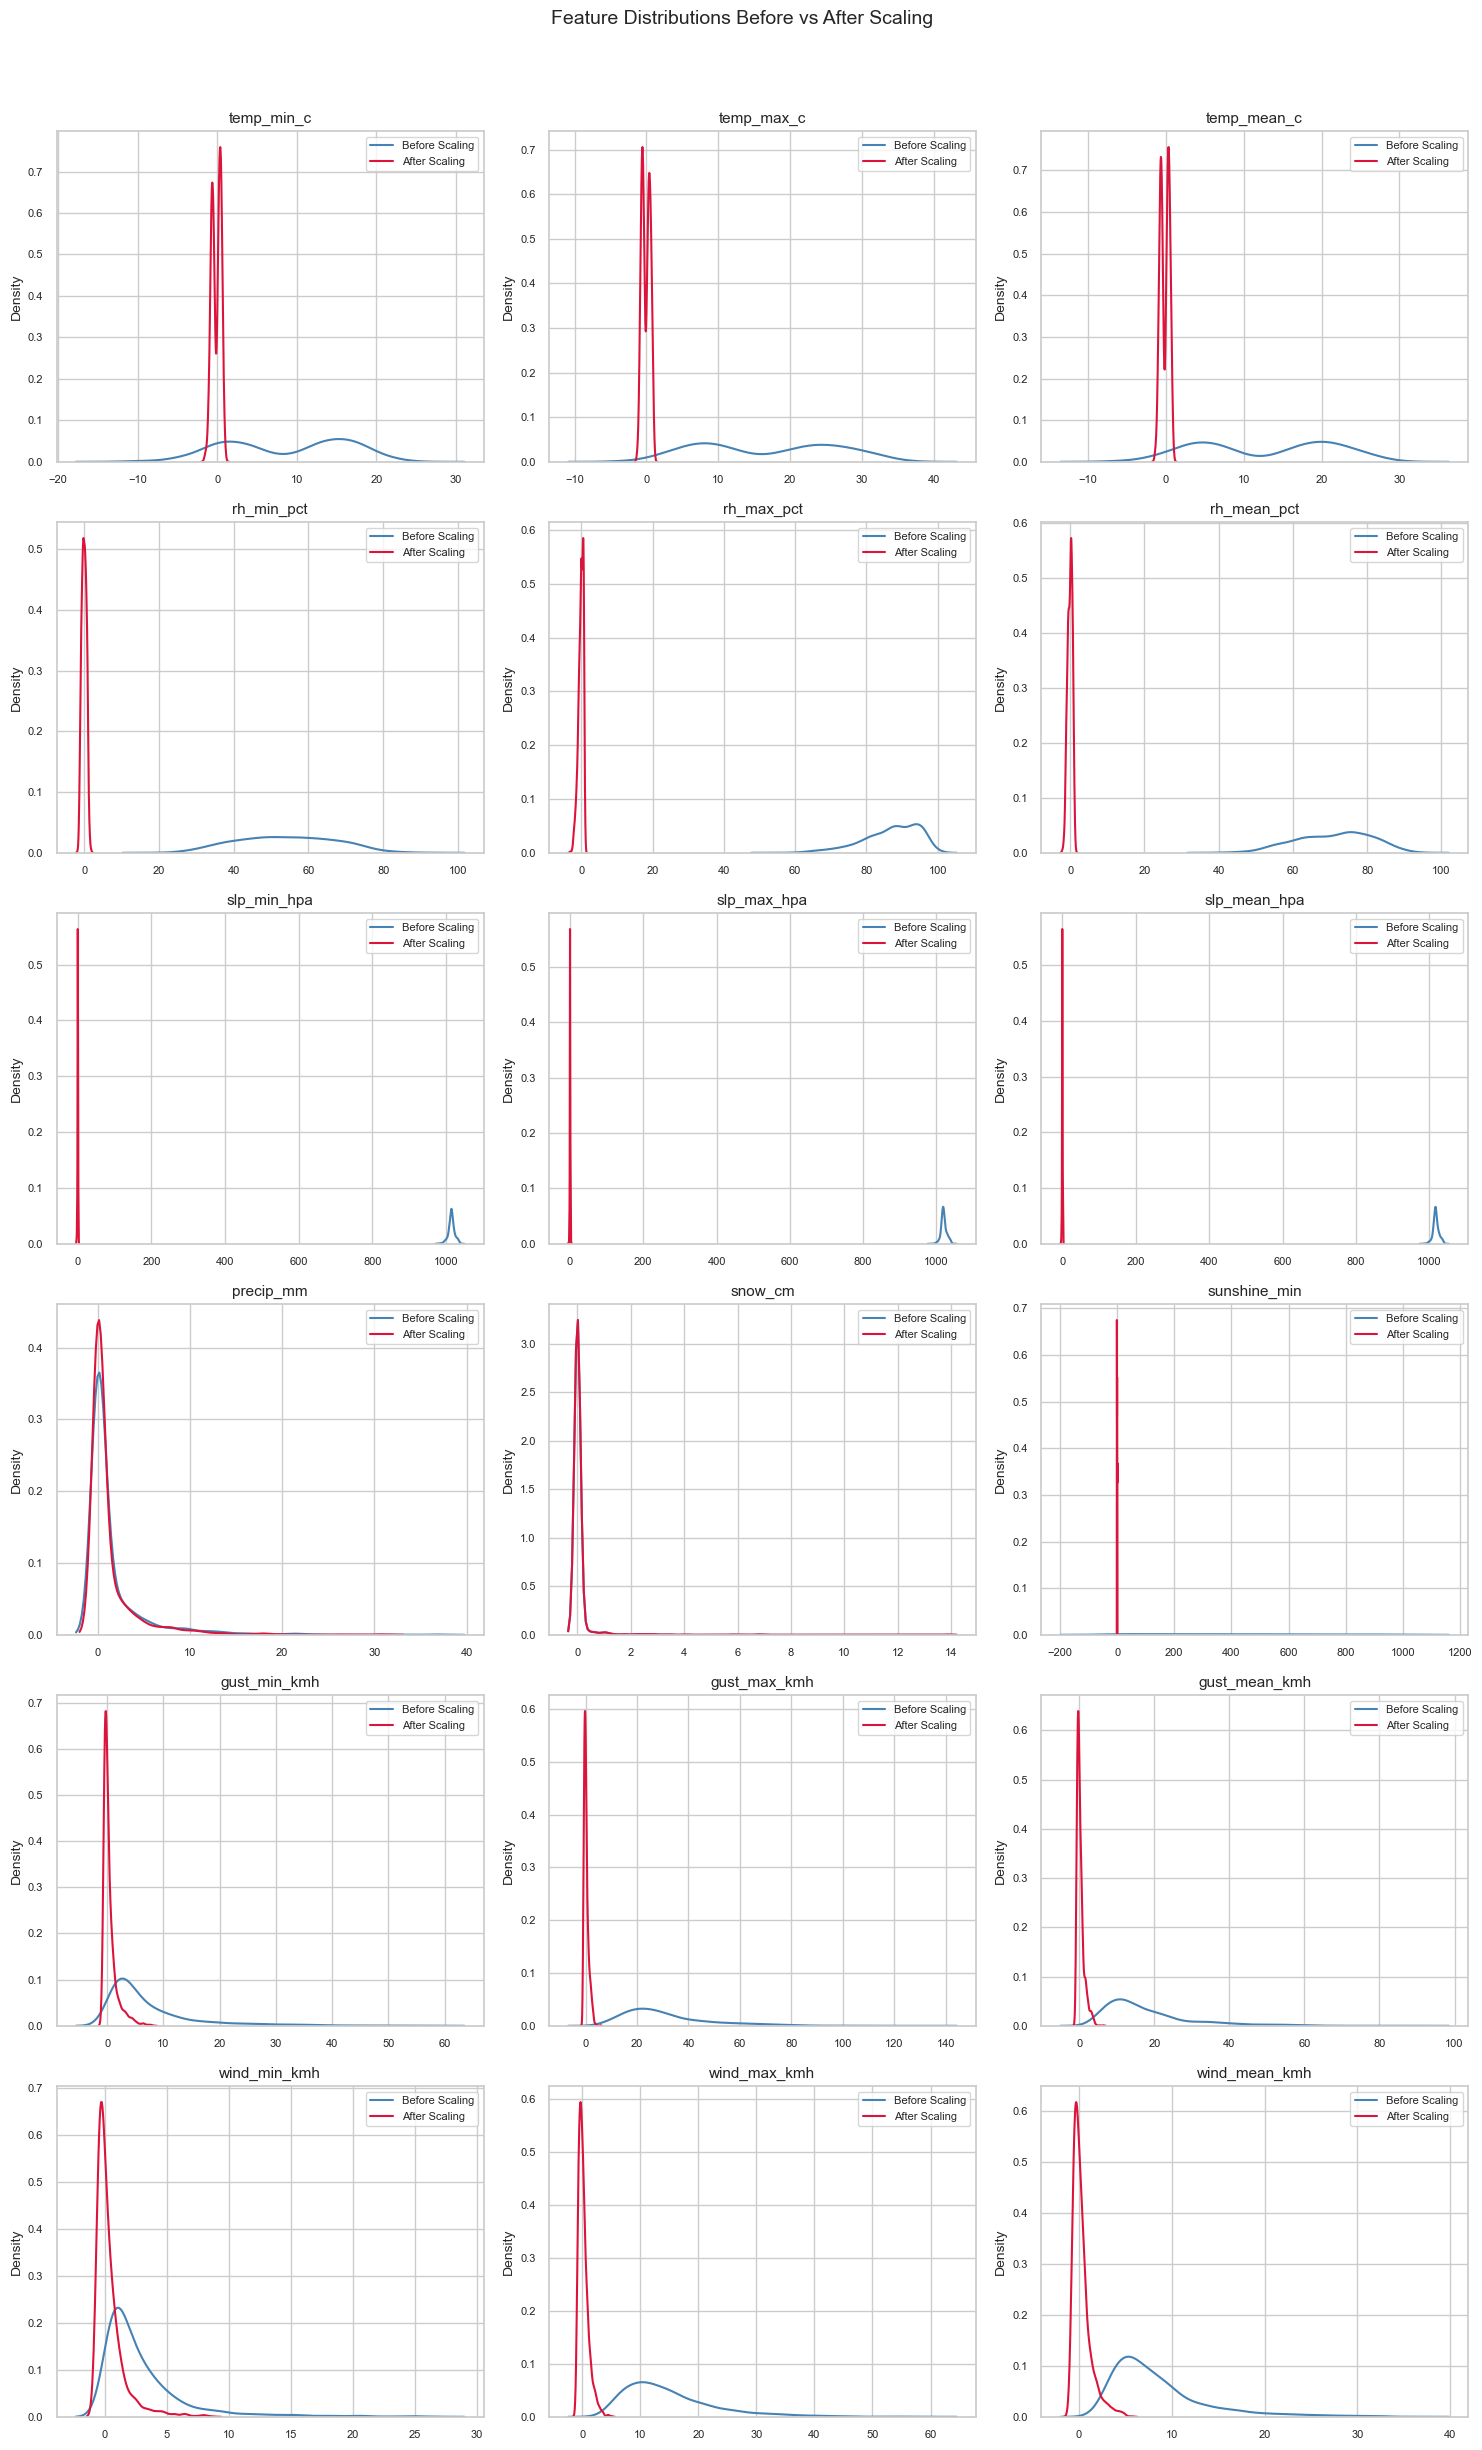

In [101]:
# compare distributions before and after scaling
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(basel_df[col], ax=axes[i], label="Before Scaling", color="steelblue")
    sns.kdeplot(basel_df_scaled[col], ax=axes[i], label="After Scaling", color="crimson")
    axes[i].set_title(col, fontsize=11)
    axes[i].legend(fontsize=8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Density")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Distributions Before vs After Scaling", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("images/feature_scaling.png")
plt.show()

In [ ]:

lof = LocalOutlierFactor(n_neighbors=20)
labels = lof.fit_predict(basel_df_scaled)
scores = -lof.negative_outlier_factor_

basel_df_scaled['lof_label'] = labels
basel_df_scaled['lof_score'] = scores

n_outliers = (labels == -1).sum()
print(f"Detected {n_outliers} outliers ({n_outliers/len(basel_df_scaled)*100:.2f}%)")

Detected 13 outliers (0.74%)


In [103]:
# cap outliers
def cap_outliers(df, lower=0.01, upper=0.99):
    l, u = df.quantile([lower, upper])
    return np.clip(df, l, u)

outlier_mask = basel_df_scaled['lof_score'] == -1
df_treated = basel_df_scaled.copy()
for col in num_cols:
    df_treated.loc[outlier_mask, col] = cap_outliers(basel_df_scaled[col])[outlier_mask]

df_treated.drop(columns=['lof_label', 'lof_score'])

,temp_min_c,temp_max_c,temp_mean_c,rh_min_pct,rh_max_pct,rh_mean_pct,slp_min_hpa,slp_max_hpa,slp_mean_hpa,precip_mm,snow_cm,sunshine_min,gust_min_kmh,gust_max_kmh,gust_mean_kmh,wind_min_kmh,wind_max_kmh,wind_mean_kmh
0,-0.152567,0.010006,-0.074530,0.35,0.727273,0.385773,-0.166667,-0.129412,-0.140230,0.166667,0.0,-0.075090,-0.162162,-0.156863,-0.162571,-0.026924,-0.284246,-0.057211
1,0.065076,0.064155,0.023529,0.25,0.545455,0.292750,-0.077778,-0.341176,-0.230132,1.583333,0.0,-0.202979,0.324324,-0.058824,0.061752,0.795416,0.362558,0.320276
2,0.007954,0.045321,-0.022285,0.85,0.727273,0.760602,0.077778,-0.235294,-0.066447,0.083333,0.0,-0.528048,-0.162162,-0.117647,-0.115942,0.056818,-0.186756,-0.108301
3,0.017354,0.446145,0.170921,0.00,0.363636,0.369357,0.144444,-0.094118,0.036174,0.000000,0.0,0.996600,-0.324324,-0.333333,-0.391934,-0.369081,-0.165510,-0.429465
4,0.154736,0.483225,0.334326,-0.35,0.000000,-0.355677,0.122222,0.141176,0.144188,0.000000,0.0,1.138607,-0.540541,-0.568627,-0.720857,-0.515402,-0.719686,-0.692911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-0.292842,-0.429076,-0.438181,1.40,0.545455,1.017784,1.222222,1.788235,1.302727,4.166667,0.0,-0.783034,0.810811,0.352941,0.405797,0.665515,0.450261,0.490750
1759,-0.605929,-0.612125,-0.639300,-0.05,0.636364,0.238030,2.233333,2.447059,2.480878,0.000000,0.0,0.232435,-0.108108,-0.176471,0.239445,-0.184541,0.137851,0.334386
1760,-0.776573,-0.775162,-0.840896,-0.70,-0.454545,-0.571819,2.455556,2.388235,2.481335,0.000000,0.0,0.205660,0.216216,-0.078431,0.245747,-0.233247,-0.296692,-0.188020
1761,-0.706435,-0.567393,-0.717853,-0.65,-1.727273,-1.220246,1.955556,2.117647,2.079178,0.000000,0.0,0.253044,-0.324324,-0.039216,0.167612,-0.553622,-0.613756,-0.644382


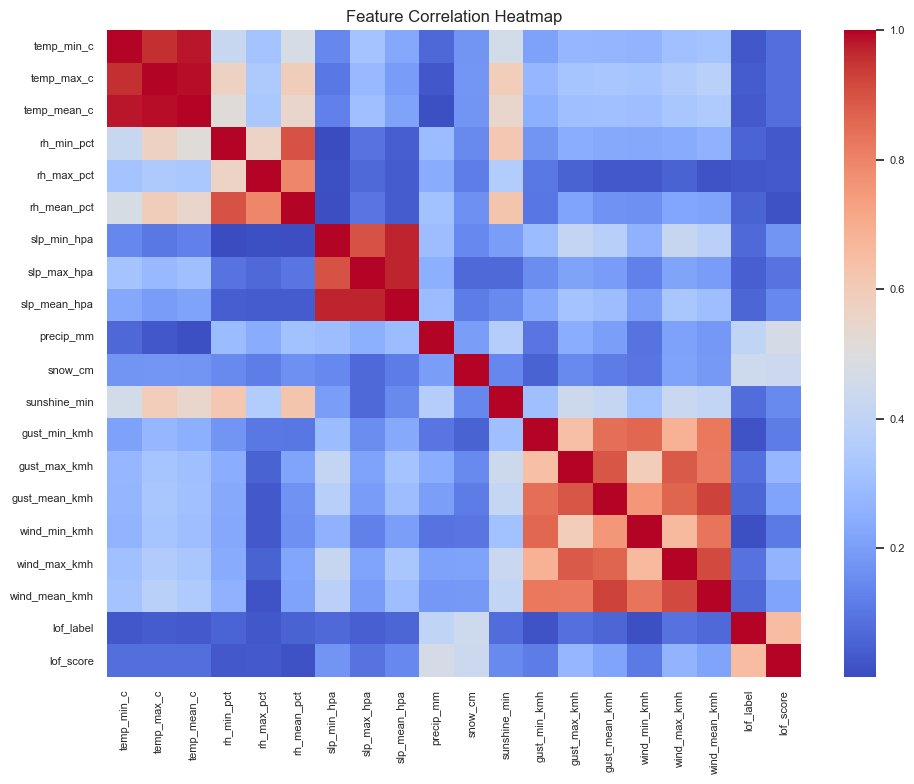

In [104]:
# Analyse feature correlation
corr = basel_df_scaled.corr().abs()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [105]:
# keep only upper triangle because correlation matrix is symmetric
# that every pair is shown twice, it might be a problem because it
# can lead to accidentially remove both features.
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] >= 0.95)]
print("Highly correlated columns to drop:", high_corr)

df_reduced = basel_df_scaled.drop(columns=high_corr)

Highly correlated columns to drop: ['temp_max_c', 'temp_mean_c', 'slp_mean_hpa']


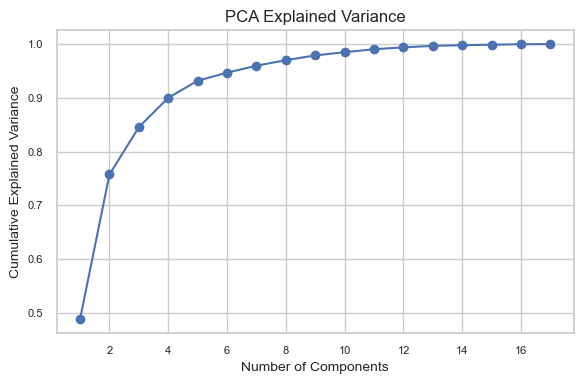

In [ ]:

pca = PCA(n_components=None)
pca.fit(df_reduced)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.savefig('images/pca_explained.png')
plt.tight_layout()
plt.show()

In [107]:
N_COMPONENTS = 4
pca_final = PCA(n_components=N_COMPONENTS)
X_pca = pca_final.fit_transform(df_reduced)

pca_df = pd.DataFrame(X_pca, columns=[f"PC{x}" for x in range(1, N_COMPONENTS+1 )])
print("Explained variance ( PCs):", pca_final.explained_variance_ratio_.sum())
pca_df

Explained variance ( PCs): 0.9001438849372168


,PC1,PC2,PC3,PC4
0,-1.187674,-0.568784,0.062242,1.206798
1,0.452831,-0.064508,0.037826,0.613611
2,-1.148690,-0.450640,0.408330,1.588173
3,-1.698547,-1.090543,-0.188742,0.616465
4,-2.076676,-1.735436,-0.542830,-0.100752
...,...,...,...,...
1758,2.807791,-0.658395,2.900561,-0.048254
1759,-1.859401,-0.568982,2.899580,-0.571710
1760,-2.135633,-0.731795,2.349785,-1.802448
1761,-2.390302,-1.292890,1.326485,-2.269176


In [ ]:
# Metrics

def compute_scores(X, labels):
    labels = np.array(labels)
    if len(np.unique(labels)) < 2:
        return dict(silhouette=np.nan, db=np.nan, ch=np.nan)

    return dict(
        silhouette = silhouette_score(X, labels),
        db         = davies_bouldin_score(X, labels),
        ch         = calinski_harabasz_score(X, labels),
    )


# K-MEANS

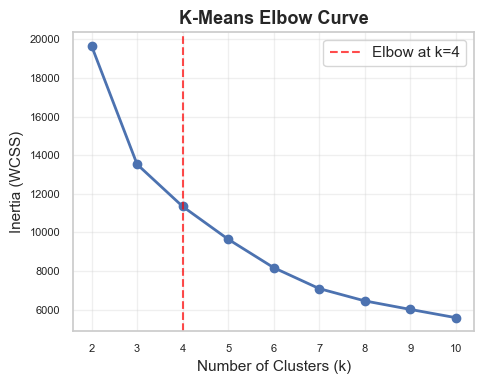

In [ ]:


k_range = range(2, 11)
kmeans_results = []

for k in k_range:
    km = KMeans(n_clusters=k, n_init=30, random_state=42)
    labels = km.fit_predict(X_pca)
    scores = compute_scores(X_pca, labels)
    inertia = km.inertia_
    kmeans_results.append(dict(k=k, model=km, labels=labels, inertia=inertia, **scores))

kmeans_df = pd.DataFrame(kmeans_results)

# Use elbow method to find optimal k
kn = KneeLocator(
    kmeans_df['k'],
    kmeans_df['inertia'],
    curve='convex',
    direction='decreasing'
)
best_k = kn.elbow

best_row = kmeans_df[kmeans_df['k'] == best_k].iloc[0]
best_model = (best_row['model'], best_row['labels'])
best_labels = best_row['labels']
best_scores = {
    'silhouette': best_row['silhouette'],
    'db': best_row['db'],
    'ch': best_row['ch']
}
kmeans_df_plot = kmeans_df.set_index("k")
# Elbow curve
plt.plot(kmeans_df_plot.index, kmeans_df_plot["inertia"], marker="o", linewidth=2)
plt.axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Elbow at k={best_k}')
plt.title("K-Means Elbow Curve", fontsize=13, fontweight='bold')
plt.xlabel("Number of Clusters (k)", fontsize=11)
plt.ylabel("Inertia (WCSS)", fontsize=11)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

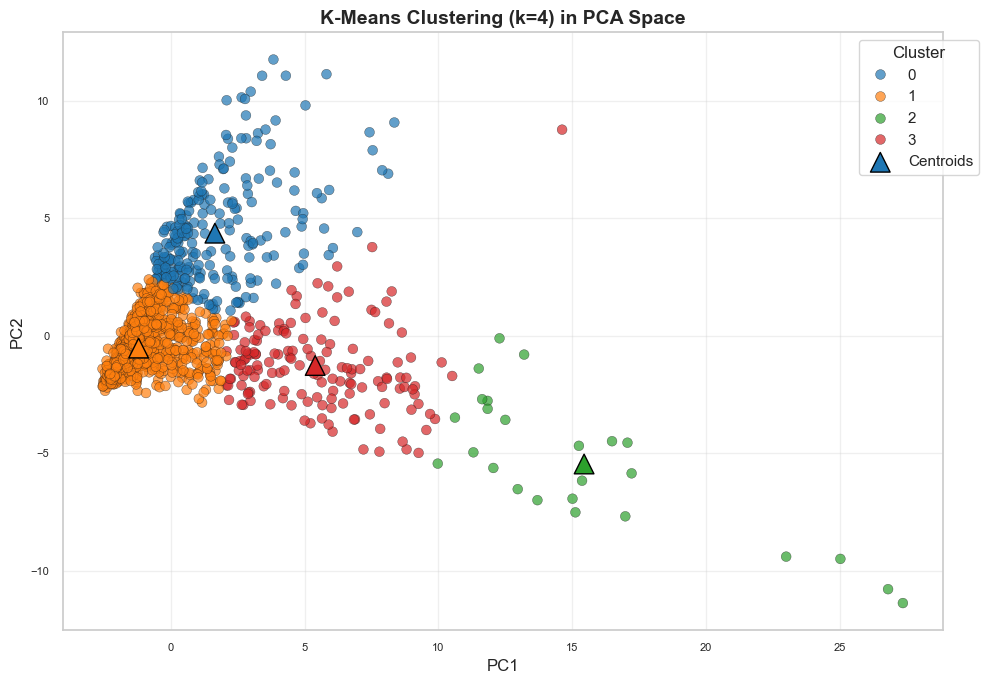

In [110]:
# Visualize best K-Means clustering result
palette = sns.color_palette("tab10", best_k)
cluster_palette = {cluster: palette[i % len(palette)] for i, cluster in enumerate(np.unique(best_labels))}

pca_plot_df = pca_df.copy()
pca_plot_df['cluster'] = best_labels

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=pca_plot_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette=cluster_palette,
    s=50, alpha=0.7, edgecolor="k", linewidth=0.3
)

# Plot centroids
centroids = best_model[0].cluster_centers_[:, :2]
centroid_colors = [cluster_palette.get(i, palette[i % len(palette)]) for i in range(best_k)]
ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="^",
    edgecolors='black',
    c=centroid_colors,
    s=200,
    label="Centroids",
)

plt.title(f"K-Means Clustering (k={best_k}) in PCA Space", fontsize=14, fontweight='bold')
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/kmeans_clustering_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

# different min_cluster_size parameters
min_cluster_sizes = [10, 15, 20, 30, 50]
hdbscan_results = []

for min_size in min_cluster_sizes:
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=min_size,
        min_samples=10,
        cluster_selection_method='eom',
        metric='euclidean'
    )
    hdb_labels = hdb.fit_predict(X_pca)
    
    # Filter out noise points for metrics calculation
    valid_mask = hdb_labels != -1
    n_clusters = len(np.unique(hdb_labels[valid_mask]))
    n_noise = np.sum(~valid_mask)
    
    # Compute metrics only on non-noise points
    if n_clusters >= 2 and np.sum(valid_mask) >= 2:
        scores = compute_scores(X_pca[valid_mask], hdb_labels[valid_mask])
    else:
        scores = {'silhouette': np.nan, 'db': np.nan, 'ch': np.nan}
    
    hdbscan_results.append({
        'min_cluster_size': min_size,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': n_noise / len(hdb_labels),
        **scores
    })

hdbscan_df = pd.DataFrame(hdbscan_results)

/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarni

# HDBSCAN

In [112]:
# Select best HDBSCAN configuration (highest silhouette score)
valid_hdbscan = hdbscan_df[hdbscan_df['silhouette'].notna()]

if len(valid_hdbscan) > 0:
    best_hdbscan_idx = valid_hdbscan['silhouette'].idxmax()
    best_min_size = int(hdbscan_df.loc[best_hdbscan_idx, 'min_cluster_size'])
else:
    # Fallback to middle value if no valid silhouette scores
    best_min_size = 20

# Re-run HDBSCAN with best parameters
hdbscan_best = hdbscan.HDBSCAN(
    min_cluster_size=best_min_size,
    min_samples=10,
    cluster_selection_method='eom',
    metric='euclidean'
)
hdbscan_labels = hdbscan_best.fit_predict(X_pca)

# Get statistics
n_clusters = len(np.unique(hdbscan_labels[hdbscan_labels != -1]))
n_noise = np.sum(hdbscan_labels == -1)


/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nhanncv/miniforge3/envs/scc451/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


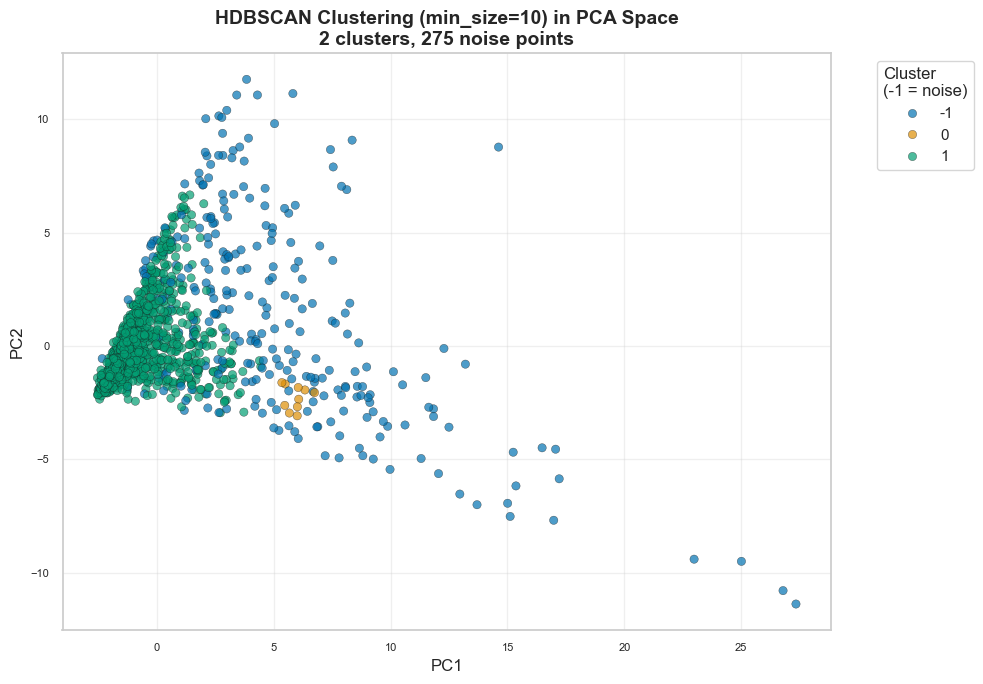

In [ ]:
pca_plot_df = pca_df.copy()
pca_plot_df['cluster'] = hdbscan_labels

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_plot_df,
    x='PC1', y='PC2',
    hue='cluster',
    palette='colorblind',
    alpha=0.7, edgecolor='k', linewidth=0.3
)
plt.title(f'HDBSCAN Clustering (min_size={best_min_size}) in PCA Space\n{n_clusters} clusters, {n_noise} noise points', 
         fontsize=14, fontweight='bold')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.legend(title='Cluster\n(-1 = noise)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/hdbscan_clustering_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Gaussian Mixture Model (GMM)

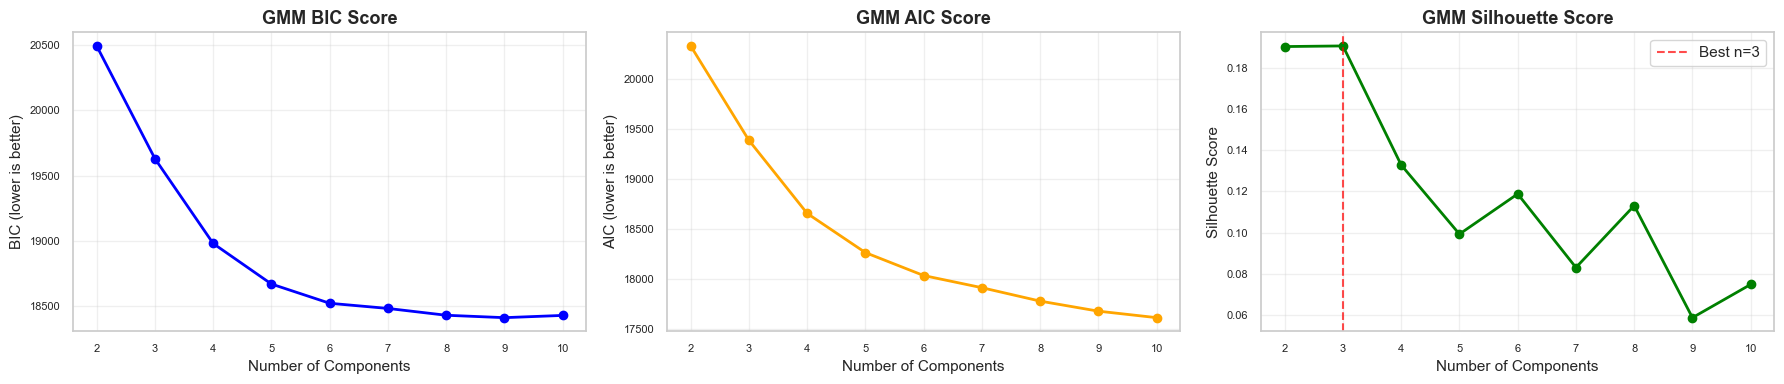

In [ ]:

n_components_range = range(2, 11)
gmm_results = []
best_gmm_model = None
best_gmm_scores = None

for n_comp in n_components_range:
    gmm = GaussianMixture(
        n_components=n_comp,
        covariance_type='full',
        n_init=10,
        random_state=42
    )
    gmm_labels = gmm.fit_predict(X_pca)
    scores = compute_scores(X_pca, gmm_labels)
    
    gmm_results.append({
        'n_components': n_comp,
        'bic': gmm.bic(X_pca),
        'aic': gmm.aic(X_pca),
        **scores
    })
    
    if np.isfinite(scores["silhouette"]) and (
        best_gmm_scores is None or scores["silhouette"] > best_gmm_scores["silhouette"]
    ):
        best_gmm_model = (gmm, gmm_labels)
        best_gmm_scores = scores

if best_gmm_model is None:
    raise RuntimeError("GMM did not produce a valid clustering.")

best_n_comp = best_gmm_model[0].n_components
best_gmm_labels = best_gmm_model[1]

gmm_df = pd.DataFrame(gmm_results).set_index('n_components')

# Visualize GMM model selection
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# BIC curve
axes[0].plot(gmm_df.index, gmm_df["bic"], marker="o", color="blue", linewidth=2)
axes[0].set_title("GMM BIC Score", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Number of Components", fontsize=11)
axes[0].set_ylabel("BIC (lower is better)", fontsize=11)
axes[0].grid(True, alpha=0.3)

# AIC curve
axes[1].plot(gmm_df.index, gmm_df["aic"], marker="o", color="orange", linewidth=2)
axes[1].set_title("GMM AIC Score", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Number of Components", fontsize=11)
axes[1].set_ylabel("AIC (lower is better)", fontsize=11)
axes[1].grid(True, alpha=0.3)

# Silhouette score
axes[2].plot(gmm_df.index, gmm_df["silhouette"], marker="o", color="green", linewidth=2)
axes[2].axvline(best_n_comp, color='red', linestyle='--', alpha=0.7, label=f"Best n={best_n_comp}")
axes[2].set_title("GMM Silhouette Score", fontsize=13, fontweight='bold')
axes[2].set_xlabel("Number of Components", fontsize=11)
axes[2].set_ylabel("Silhouette Score", fontsize=11)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/gmm_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


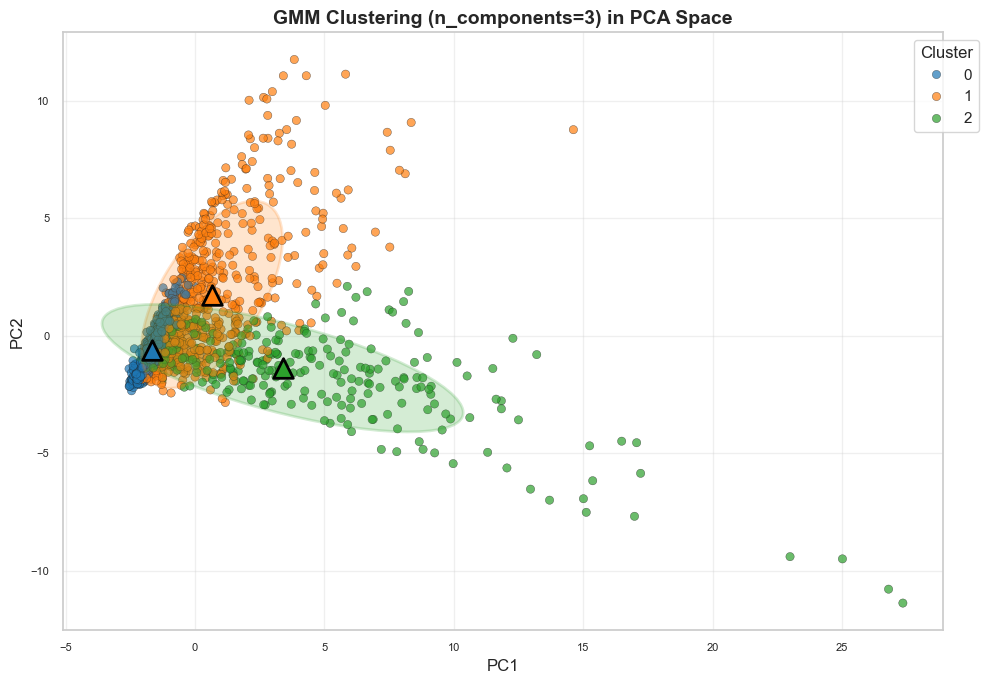

In [ ]:


pca_plot_df = pca_df.copy()
pca_plot_df['cluster'] = best_gmm_labels

plt.figure(figsize=(10, 7))
ax = plt.gca()

palette = sns.color_palette("tab10", best_n_comp)
cluster_palette = {cluster: palette[i % len(palette)] for i, cluster in enumerate(np.unique(best_gmm_labels))}

sns.scatterplot(
    data=pca_plot_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette=cluster_palette,
    alpha=0.7, edgecolor="k", linewidth=0.3,
    ax=ax
)

# Plot Gaussian ellipses for each component
gmm_model = best_gmm_model[0]
for i in range(best_n_comp):
    mean = gmm_model.means_[i, :2]
    covar = gmm_model.covariances_[i, :2, :2]
    
    # Calculate eigenvalues and eigenvectors for the covariance matrix
    v, w = np.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)  # 95% confidence interval
    u = w[0] / np.linalg.norm(w[0])
    
    # Calculate angle
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    
    # Create and add ellipse
    color = cluster_palette.get(i, palette[i % len(palette)])
    ell = Ellipse(mean, v[0], v[1], angle=180.0 + angle, 
                  color=color, alpha=0.2, linewidth=2, fill=True)
    ax.add_patch(ell)
    
    # Plot means
    ax.scatter(mean[0], mean[1], marker='^', c=[color], edgecolors='black', s=200, linewidth=2, zorder=10)

plt.title(f"GMM Clustering (n_components={best_n_comp}) in PCA Space", 
         fontsize=14, fontweight='bold')
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/gmm_clustering_visualization.png', dpi=300, bbox_inches='tight')
plt.show()